<a href="https://colab.research.google.com/github/hopesofbuzzy/URFU_adii/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B8/5/%D0%92%D0%B8%D0%B7%D1%83%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузки

Необходимые загрузки библиотек

In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [471]:
from google.colab import files #to upload files Для загрузки файлов, не менять

#files.upload()

# Сводная таблица и математические методы

In [472]:
#df = pd.read_excel('Для диаграмм с усами.xlsx', sheet_name='А2')
#print(df)

In [473]:
def calculate_median_ci(data):
    """
    Расчет медианы и 95% доверительного интервала для медианы
    """
    n = len(data)
    # print('n = ',n)
    if n == 0:
        return np.nan, (np.nan, np.nan)

    # Сортируем данные
    sorted_data = np.sort(data)

    # Вычисляем параметр k
    k = int(np.floor(n/2 - 1.96 * np.sqrt(n)/2))
    k = max(0, k)  # k не может быть отрицательным

    # Вычисляем границы доверительного интервала
    lower_idx = k
    upper_idx = n - k - 1  # -1 потому что индексы с 0
    # print('lower_idx = ', lower_idx, 'upper_idx = ', upper_idx)

    median = np.median(data)
    lower_ci = sorted_data[lower_idx]
    upper_ci = sorted_data[upper_idx]

    return median, (lower_ci, upper_ci)

In [474]:
def calculate_mean_ci(data):
    """
    Расчет среднего и 95% доверительного интервала для среднего
    """
    n = len(data)
    if n == 0:
        return np.nan, (np.nan, np.nan)

    # Вычисляем среднее
    mean = np.mean(data)

    # Вычисляем стандартную ошибку среднего
    sem = stats.sem(data)

    # Вычисляем 95% доверительный интервал using t-distribution
    ci = stats.t.interval(0.95, df=n-1, loc=mean, scale=sem)

    return mean, ci

In [475]:
import string

def float_nan(s):
  """
  Форматирование входных данных ячейки таблицы в float
  """
  if not str(s)[0] in string.digits + '-':
    return 0.0
  else:
    return float(s)

def list_float_nan(l):
  return [float(str(i).replace(',', '.')) for i in l if str(i)[0] in string.digits + '-']

def list_nan(l):
  return [i for i in l if str(i) != 'nan']

In [476]:
# Дополнительная функция для создания сводной таблицы
def create_summary_table(file_path_arg: str, sheet_name_arg, group_names: dict={1: 'Группа 1', 2: 'Группа 2'}):
    """
    Создание сводной таблицы с результатами

    :param file_path: путь файла с таблицой
    :param sheet_name: лист таблицы для анализа
    :param group_names: обозначения для групп в словаре
    """
    df = pd.read_excel(file_path_arg, sheet_name=sheet_name_arg)
    group_col_name = df.columns[0]  # сохраняем название колонки
    # map - использует введённое в dict обозначение для всех элементов столбца Инсульт
    # этим же самым избавляемся от nan
    df[group_col_name] = df[group_col_name].map(group_names)
    group_col = df.columns[0]
    indicators = df.columns[1:]
    # Получаем все группы из первого столбца
    r = list_nan(list(df[group_col].unique()))
    groups = sorted(r)

    summary_data = []
    for indicator in indicators:
      #if not results or indicator in results:
        for group in groups:
            #if not results or group in results.get(indicator):
                # data = results[indicator][group]
                data = list(list_float_nan(list(df[df[group_col] == group][indicator])))
                median, ci = calculate_median_ci(data)
                summary_data.append({
                    'Показатель': indicator,
                    'Группа': group,
                    'n': len(data), # data['n'],
                    'Медиана': f"{median:.2f}",
                    '95% ДИ нижняя': f"{ci[0]:.2f}",
                    '95% ДИ верхняя': f"{ci[1]:.2f}",
                    'ДИ': f"[{ci[0]:.2f}; {ci[1]:.2f}]"
                })

    summary_df = pd.DataFrame(summary_data)
    #summary_df.to_excel('clinical_study_summary.xlsx', index=False)
    #print("Сводная таблица сохранена как 'clinical_study_summary.xlsx'")
    return summary_df

Нужно учесть, что может быть не 0 и 1, а 1 и 2

In [477]:
# results = {
#     'PSV': ['Пациенты с АГ и МФА'],
#     'PI': ['Пациенты с АГ и МФА']
# }
group_names = {1: 'Группа 1', 2: 'Группа 2'}
create_summary_table('Для диаграмм с усами.xlsx', sheet_name_arg='А3', group_names=group_names)


,Показатель,Группа,n,Медиана,95% ДИ нижняя,95% ДИ верхняя,ДИ
0,ХС п,Группа 1,55,4.08,3.97,4.20,[3.97; 4.20]
1,ХС п,Группа 2,55,4.28,4.05,4.58,[4.05; 4.58]
2,ЛПНП п,Группа 1,55,2.14,2.06,2.32,[2.06; 2.32]
3,ЛПНП п,Группа 2,55,2.40,2.11,2.56,[2.11; 2.56]
4,ЛПВП п,Группа 1,55,1.50,1.39,1.66,[1.39; 1.66]
5,ЛПВП п,Группа 2,55,1.44,1.30,1.55,[1.30; 1.55]
6,ТГ п,Группа 1,55,1.31,1.15,1.48,[1.15; 1.48]
7,ТГ п,Группа 2,55,1.20,1.05,1.39,[1.05; 1.39]
8,ХС-неЛНП п,Группа 1,55,2.62,2.38,2.79,[2.38; 2.79]
9,ХС-неЛНП п,Группа 2,55,2.89,2.65,3.01,[2.65; 3.01]


In [478]:
class AnalyzeSettings:
  '''
    Конфигурация анализа клинических данных

    :param file_path: путь файла с таблицой
    :param sheet_name: лист таблицы для анализа
    :param group_names: обозначения для групп в словаре
    :param pvalue: коэффициент Пирсона
  '''
  def __init__(self, file_path, sheet_name, analyze_func, group_names, pvalues):
    self.file_path = file_path
    self.sheet_name = sheet_name
    self.analyze_func = analyze_func
    self.group_names = group_names
    self.pvalues = pvalues

class GraphicSettings:
  '''
    Конфигурация графической настройки диаграмм
  '''
  def __init__(self, colors, titletext, titlesize, titleweight, xtext, xfontsize, xfontweight, ytext, yfontsize, yfontweight):
    self.colors = colors
    self.titletext = titletext
    self.titlesize = titlesize
    self.titelweight = titleweight
    self.xtext = xtext
    self.xfontsize = xfontsize
    self.xfontweight = xfontweight
    self.ytext = ytext
    self.yfontsize = yfontsize
    self.yfontweight = yfontweight

# Визуализация

In [479]:
def wrap_labels(labels, width=12):
    """Переносит длинные подписи по словам"""
    wrapped_labels = []
    for label in labels:
        words = str(label).split()
        lines = []
        current_line = []
        for word in words:
            if len(' '.join(current_line + [word])) <= width:
                current_line.append(word)
            else:
                if current_line:
                    lines.append(' '.join(current_line))
                current_line = [word]
        if current_line:
            lines.append(' '.join(current_line))
        wrapped_labels.append('\n'.join(lines))
    return wrapped_labels

Исправить комментарии с цветами

In [480]:
def create_grouped_bar_chart(results, groups, indicators, aset: AnalyzeSettings, gset: GraphicSettings):
    """
    Создание сгруппированной столбчатой диаграммы

    :param results: данные для визуализации
    :param groups: группы для группировки данных
    :param indicators: индикаторы для группировки данных
    :param gset: конфигурация для графической настройки диаграмм
    """
    n_indicators = len(indicators)
    n_groups = len(groups)

    # Загрузка настроек
    pvalues = aset.pvalues
    # Цвета для групп
    colors = gset.colors[:n_groups]

    # Настройка графика
    fig, ax = plt.subplots(figsize=(max(8, n_indicators * 1.4), 8))

    # Ширина столбцов и позиции
    bar_width = 0.8 / n_groups
    x_pos = np.arange(n_indicators)

    # Создаем столбцы для каждой группы
    for i, group in enumerate(groups):
        medians = []
        ci_lower_errors = []
        ci_upper_errors = []

        for indicator in indicators:
            if group in results[indicator]:
                data = results[indicator][group]
                medians.append(data['median'])
                # Для ошибок: нижняя ошибка = медиана - нижняя граница ДИ
                # верхняя ошибка = верхняя граница ДИ - медиана
                lower_error = data['median'] - data['ci_lower']
                upper_error = data['ci_upper'] - data['median']
                ci_lower_errors.append(lower_error)
                ci_upper_errors.append(upper_error)
            else:
                medians.append(0)
                ci_lower_errors.append(0)
                ci_upper_errors.append(0)

        # Позиции для текущей группы
        positions = x_pos + i * bar_width - (n_groups - 1) * bar_width / 2

        #min_height_in_group = min(medians) if medians else 0
        #common_label_height = min_height_in_group * 0.6

        # Столбцы с ошибками
        # РИСУЕМ СТОЛБЦЫ
        # medians - высоты столбцов
        bars = ax.bar(positions, medians, bar_width,
                     label=f' {group}', color=colors[i],
                     yerr=[ci_lower_errors, ci_upper_errors],
                     capsize=5, error_kw={'elinewidth': 2, 'markeredgewidth': 2})
        for bar, median in zip(bars, medians):
            height = bar.get_height()
        #    ax.text(bar.get_x() + bar.get_width()/2., height/2, #common_label_height
        #           f'{median:.0f}', ha='center', va='center',
        #           fontweight='bold', color='#000080', fontsize=16)

        # Добавляем p-value над каждой группой столбцов
        if pvalues:
            # Находим общий максимум по всем данным для установки верхнего предела
            all_max = 0
            for indicator in indicators:
                for group in groups:
                    if group in results[indicator]:
                        data = results[indicator][group]
                        if data['ci_upper'] > all_max:
                            all_max = data['ci_upper']

            for i, indicator in enumerate(indicators):
                if indicator in pvalues:
                    # Находим максимальную высоту среди всех столбцов для этого показателя
                    max_height = 0
                    for group in groups:
                        if group in results[indicator]:
                            data = results[indicator][group]
                            height = data['ci_upper']
                            if height > max_height:
                                max_height = height

                    # Вычисляем позицию для p-value - над самым высоким столбцом, но не выходя за границы
                    text_height = min(max_height + 0.05 * all_max, all_max * 1.05)

                    # Добавляем текст p-value
                    p_data = pvalues[indicator]
                    p_text = p_data[0]  # текст p-value
                    p_style = p_data[1] # флаг стиля
                    x_position = x_pos[i]
                    if p_style == 1:
                        text_props = {'color': 'red', 'fontweight': 'bold', 'fontsize': 15}
                    else:
                        text_props = {'color': 'black', 'fontweight': 'normal', 'fontsize': 14}
                    ax.text(x_position, text_height,
                          p_text,
                          ha='center', va='bottom', **text_props)

            # Немного расширяем верхнюю границу графика чтобы вместить p-value
            # УСТАНАВЛИВАЕМ ВЕРХНИЙ ПРЕДЕЛ ГРАФИКА
            ax.set_ylim(top=all_max * 1.15)

    # Настройка внешнего вида
    ax.set_xlabel(gset.xtext, fontsize=gset.xfontsize, fontweight=gset.xfontweight)
    ax.set_ylabel(gset.ytext, fontsize=gset.yfontsize, fontweight=gset.yfontweight)
    ax.set_title(gset.titletext, fontsize=gset.titlesize, fontweight=gset.titelweight)

    ax.set_xticks(x_pos)
    wrapped_indicators = wrap_labels(indicators)
    ax.set_xticklabels(wrapped_indicators, rotation=0, ha='center')  # убрал наклон
    #ax.set_xticklabels(indicators, rotation=0, ha='right')
    ax.legend(fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Сохраняем график
    #plt.savefig('clinical_study_results.png', dpi=300, bbox_inches='tight')
    #print("\nГрафик сохранен как 'clinical_study_results.png'")


# Анализ клинических данных

In [481]:
def create_summary_dict(aset):
    """
    Анализ введённых данных наподобие create_summary_table, но с выводом словаря

    :param aset: конфигурация для анализа

    :return summary_data: - словарь вида
            {
            'РF ': {
              'Пациенты с АГ и МФА': {
                'n': 55,
                'median': np.float64(95.0),
                'ci_lower': np.float64(95.0),
                'ci_upper': np.float64(95.0),
                'ДИ': '[95.00; 95.00]'
                }
              }
            }
      :return groups: группы для группировки
      :return indicator: индикаторы для группировки
    """
    # Загрузка настроек
    file_path = aset.file_path
    sheet_name = aset.sheet_name
    group_names = aset.group_names
    # results = aset.results
    results = {}

    df = pd.read_excel(file_path, sheet_name)
    group_col_name = df.columns[0]  # сохраняем название колонки
    # map - использует введённое в dict обозначение для всех элементов столбца Инсульт
    # этим же самым избавляемся от nan
    df[group_col_name] = df[group_col_name].map(group_names)
    group_col = df.columns[0]
    indicators = df.columns[1:]
    # Получаем все группы из первого столбца
    r = list_nan(list(df[group_col].unique()))

    groups = sorted(r)

    summary_data = {}
    for indicator in indicators:
      if not results or indicator in results:
        for group in groups:
            if not results or group in results.get(indicator):
                #
                data = list(list_float_nan(list(df[df[group_col] == group][indicator])))
                median, ci = aset.analyze_func(data)
                summary_data[indicator] = summary_data.setdefault(indicator, {})
                summary_data[indicator][group] = summary_data[indicator].setdefault(group, {})
                summary_data[indicator][group] = {
                    'n': len(data), # data['n'],
                    'median': median,
                    'ci_lower': ci[0],
                    'ci_upper': ci[1],
                    'ДИ': f"[{ci[0]:.2f}; {ci[1]:.2f}]"
                }
    return summary_data, groups, indicators

In [482]:
def analyze_clinical_data(aset: AnalyzeSettings, gset: GraphicSettings):
  #
    """
    Основная функция для анализа клинических данных и визуализации диаграмм

    :param aset: конфигурация для анализа клинических данных
    :param gset: конфигурация для графической настройки диаграмм
    """
    # Строим словари с данными, получаем группы и индикаторы
    results, groups, indicators = create_summary_dict(aset)

    # Визуализация данных
    create_grouped_bar_chart(results, groups, indicators, aset, gset)

    return results

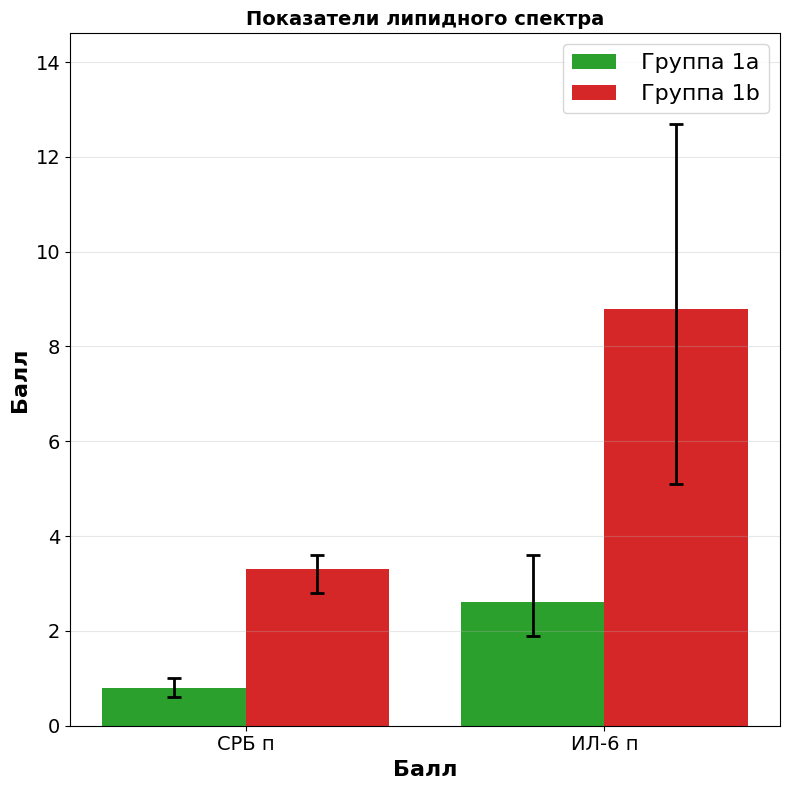

In [483]:
# Настройки
aset = AnalyzeSettings(
    file_path="Для диаграмм с усами.xlsx",
    sheet_name="А5",
    #sheet_name="А3",
    analyze_func=calculate_median_ci,
    group_names={1: 'Группа 1a', 2: 'Группа 1b'},
    pvalues={'ХС п': ['p = 0,015', 1], 'ЛПНП п': ['p = 0,068', 0], 'ЛПВП п' : ['p = 0.519', 0],	'ТГ п' : ['p = 0.236', 0], 'ХС-неЛНП п' : ['p = 0.790', 0]})
gset = GraphicSettings(
    colors=['#2ca02c', '#d62728'],
    titletext='Показатели липидного спектра',
    titlesize=14,
    titleweight='bold',
    xtext='Балл',
    xfontsize=16,
    xfontweight='bold',
    ytext='Балл',
    yfontsize=16,
    yfontweight='bold'
)

# Запуск анализа
results = analyze_clinical_data(aset, gset)


In [484]:
plt.rcParams.update(plt.rcParamsDefault)

# Доп. данные

Различные p_values:

pvalues = {'РF': ['p < 0,001', 1], 'RP': ['p < 0,001', 1],  'BP': [' ', 0], 'GH': ['p < 0,001', 1],
           'VT': ['p = 0,004', 1], 'SF': [' ', 0], 'RE': ['p = 0,002', 1], 'MH': ['p < 0,001', 1], 'PCS': ['p < 0,001', 1], 'MCS': ['p = 0,002', 1]}

pvalues = {'Вена Розенталя': ['p < 0,001', 1], 'Внутренняя яремная вена': ['p = 0,012', 1], 'Позвоночная вена': ['p < 0,001', 1]}

pvalues = {'Вена Розенталя': ['p = 0,107', 0], 'Внутренняя яремная вена': ['p = 0,531', 0], 'Позвоночная вена': ['p = 0,257', 0]}

pvalues = {'PSV': ['p = 0,030', 1], 'EDV': ['p = 0,040', 1], 'TAV': ['p = 0,002', 1]}#А7_оса_1

pvalues = {'RI': ['p < 0,001', 1], 'PI': ['p = 0,005', 1]}##А7_оса_2

pvalues = {'PSV': ['p = 0,288', 0], 'EDV': ['p = 0,006', 1], 'TAV': ['p = 0,028', 1]}#А7_вса_1

pvalues = {'RI': ['p < 0,001', 1], 'PI': ['p = 0,017', 1]}##А7_вса_2

pvalues = {'PSV': ['p = 0,676', 0], 'EDV': ['p = 0,408', 0], 'TAV': ['p = 0,010', 1]}#А7_сма_1

pvalues = {'RI': ['p < 0,001', 1], 'PI': ['p = 0,021', 1]}##А7_сма_2

pvalues = {'PSV': ['p = 0,092', 0], 'EDV': ['p = 0,026', 1], 'TAV': ['p = 0,265', 0]}#А7_па_1

pvalues = {'RI': ['p = 0,034', 1], 'PI': ['p = 0,004', 1]}##А7_па_2

pvalues = {'РF': [' ', 0], 'RP': ['p < 0,001', 1],  'BP': ['p = 0,025', 1], 'GH': [' ', 0],
               'VT': [' ', 0], 'SF': [' ', 0], 'RE': ['p = 0,019', 1], 'MH': [' ', 0], 'PCS': ['p < 0,001', 1], 'MCS': [' ', 0]}

pvalues = {'PSV': ['p = 0,925', 0], 'EDV': ['p = 0,024', 1], 'TAV': ['p = 0,007', 1]}#А8_оса_1

pvalues = {'RI': ['p = 0,793', 0], 'PI': ['p = 0,026', 1]}##А8_оса_2

pvalues = {'PSV': ['p = 0,776', 0], 'EDV': ['p = 0,012', 1], 'TAV': ['p = 0,012', 1]}#А8_вса_1

pvalues = {'RI': ['p = 0,073', 0], 'PI': ['p = 0,017', 1]}##А8_вса_2

pvalues = {'PSV': ['p = 0,861', 0], 'EDV': ['p = 0,163', 0], 'TAV': ['p = 0,482', 0]}#Лист2_1

pvalues = {'RI': ['p = 0,756', 0], 'PI': ['p = 0,492', 0]}#Лист2_2

pvalues = {'МНО y.e.' : ['p = 0.409', 0],  'Фибриноген г/л' : ['p = 0.008', 1], 'Д-димер мкг/мл' : ['p = 0.001', 1]}#A2_1

pvalues = {'ПТИ %': ['p = 0,658', 0], 'АЧТВ сек' : ['p = 0.147', 0], 'АТ III %' : ['p = 0.297', 0]}#A2_2

pvalues = {'ОХС': ['p = 0,015', 1], 'ХС ЛНП': ['p = 0,068', 0], 'ХС ЛВП' : ['p = 0.519', 0],	'ТГ' : ['p = 0.236', 0], 'ХС неЛВП' : ['p = 0.790', 0]}#A3

pvalues = {'ОХС': ['p = 0,045', 1], 'ХС ЛНП': ['p = 0,031', 1], 'ХС ЛВП' : ['p = 0.641', 0],	'ТГ' : ['p = 0.802', 0], 'ХС неЛВП' : ['p = 0.028', 1]}#A3

pvalues = {'СРБ (мг/л)': ['p < 0,001', 1], 'ИЛ-6 (пг/л)': ['p = 0,003', 1]}#А5

pvalues = {'СРБ (мг/л)': ['p < 0,001', 1], 'ИЛ-6 (пг/л)': ['p < 0,001', 1]}#А51


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

colors = ['#ffb6c1', '#0060a0']#{1: 'Основная', 2: 'Контрольная'}

colors = ['#003366', '#48D1CC']# groups_names = {1: 'Группа комбинированной терапии', 0: 'Группа стандартной терапии'}

colors = ['#9467bd', '#8c564b']#{3: 'Подгруппа 2a', 4: 'Подгруппа 2b'}

colors = ['#DC143C', '#87CEEB'] # {0: 'Пациенты с АГ и МФА', 1: 'Пациенты с АГ и МФА + ИИ'}

colors = ['#6699CC', '#F4A460'] #До и после для листа 8

colors = ['#0066FF', '#FFFF00'] #До и после для листа 7

Настройка внешнего вида

ax.set_xlabel(' ', fontsize=16, fontweight='bold')

ax.set_xlabel('Скоростные показатели ОСА, см/с', fontsize=16, fontweight='bold')

ax.set_xlabel('Индексы резистивности ОСА', fontsize=16, fontweight='bold')

ax.set_ylabel(gset.ytext, fontsize=gset.yfontsize, fontweight=gset.yfontweight)

ax.set_ylabel('см/с', fontsize=16, fontweight='bold')

ax.set_ylabel('ммоль/л', fontsize=16, fontweight='bold')

ax.set_ylabel('Медиана с 95% ДИ', fontsize=16, fontweight='bold')

ax.set_title(gset.titletext, fontsize=gset.titlesize, fontweight=gset.titelweight)

ax.set_title('Показатели липидного спектра', fontsize=14, fontweight='bold')

ax.set_title('Общая сонная артерия', fontsize=14, fontweight='bold')

ax.set_title('Внутренняя сонная артерия', fontsize=14, fontweight='bold')

ax.set_title('Средняя мозговая артерия', fontsize=14, fontweight='bold')

ax.set_title('Позвоночная артерия', fontsize=14, fontweight='bold')